In [ ]:
# pip install scikit-image

In [2]:
import pickle
import main
import main_comp

%load_ext autoreload
%autoreload 1
%aimport main
%aimport main_comp

In [3]:
def save_logs(directory, logs):
    for log_name, log in logs.items():
        with open(directory + log_name, 'wb') as f:
            f.write(pickle.dumps(log))

# Original NN

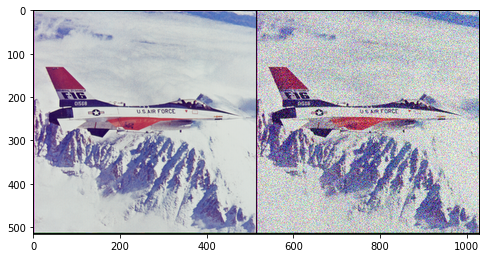

Number of params: 2217831
Starting optimization with ADAM


/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main.py:134: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_noisy = compare_ssim(img_noisy_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)
/home/Skoltech_MSc/TDTN/final_project/denoising_compression/main.py:135: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_gt = compare_ssim(img_np.T, out.detach().cpu().numpy()[0].T, multichannel=True)


Iteration 00000  Loss 0.131515  PSNR_noisy: 8.810240  PSNR_gt: 9.566223  PSNR_gt_sm: 9.566223  SSIM_noisy: 0.085054  SSIM_gt: 0.514666


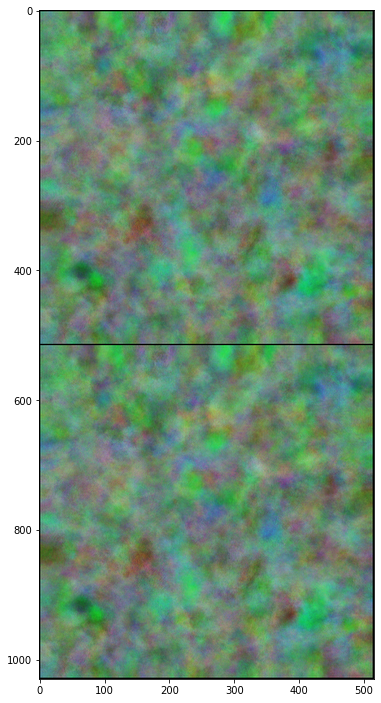

Iteration 00001  Loss 0.102565  PSNR_noisy: 9.890003  PSNR_gt: 11.015605  PSNR_gt_sm: 9.593357  SSIM_noisy: 0.091019  SSIM_gt: 0.587673
Iteration 00002  Loss 0.076161  PSNR_noisy: 11.182690  PSNR_gt: 12.943027  PSNR_gt_sm: 9.637059  SSIM_noisy: 0.096267  SSIM_gt: 0.684123
Iteration 00003  Loss 0.093342  PSNR_noisy: 10.299233  PSNR_gt: 11.708070  PSNR_gt_sm: 9.686587  SSIM_noisy: 0.094421  SSIM_gt: 0.667554
Iteration 00004  Loss 0.072560  PSNR_noisy: 11.393033  PSNR_gt: 13.511540  PSNR_gt_sm: 9.755083  SSIM_noisy: 0.097822  SSIM_gt: 0.708389
Iteration 00005  Loss 0.066703  PSNR_noisy: 11.758554  PSNR_gt: 14.241399  PSNR_gt_sm: 9.833383  SSIM_noisy: 0.098517  SSIM_gt: 0.714255
Iteration 00006  Loss 0.066568  PSNR_noisy: 11.767344  PSNR_gt: 14.255898  PSNR_gt_sm: 9.911177  SSIM_noisy: 0.098678  SSIM_gt: 0.718211
Iteration 00007  Loss 0.062757  PSNR_noisy: 12.023405  PSNR_gt: 14.706334  PSNR_gt_sm: 9.988575  SSIM_noisy: 0.098696  SSIM_gt: 0.717938
Iteration 00008  Loss 0.061377  PSNR_noisy

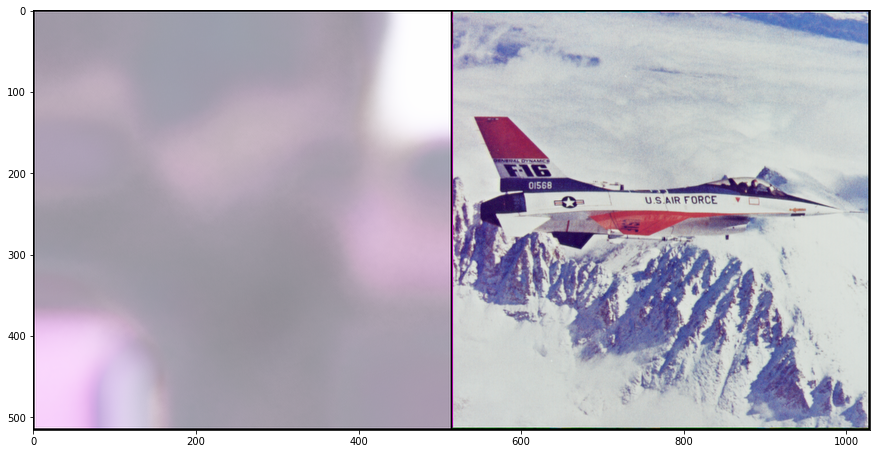

In [4]:
losses, psnrs_noisy, psnrs_gt, ssims_noisy, ssims_gt = main.main_func(True, device='cuda')

In [5]:
save_logs(
    './logs/', 
    {
        'losses': losses, 
        'psnrs_noisy': psnrs_noisy, 
        'psnrs_gt': psnrs_gt, 
        'ssims_noisy': ssims_noisy, 
        'ssims_gt': ssims_gt
    }
)

# Compressed NN

In [6]:
from models.skip import skip

In [7]:
input_depth = 32
n_channels = 3
skip_n33d = 128
skip_n33u = 128
skip_n11 = 4
num_scales = 5
upsample_mode = 'bilinear'
downsample_mode = 'stride'
pad = 'reflection'
act_fun = 'LeakyReLU'

In [8]:
net = skip(
    input_depth, 
    n_channels,
    num_channels_down=[skip_n33d] * num_scales,
    num_channels_up=[skip_n33u] * num_scales,
    num_channels_skip=[skip_n11] * num_scales,
    upsample_mode=upsample_mode, 
    downsample_mode=downsample_mode,
    need_sigmoid=True, 
    need_bias=True,
    pad=pad, 
    act_fun=act_fun
)
net

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
  

In [9]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module


def replace_conv_layer_by_name(model, mname, new_layer):
    '''
    Replace layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list[:-1]:
        module = module._modules[mname]
    module._modules[mname_list[-1]] = new_layer

In [10]:
def calculate_layer_cr(model_stats, lnames_to_compress, cr=2):
    '''
    When we compres whole model with compression ratio `cr`,
    we need to calculate layer compression ratio for each layer
    from `lnames_to_compress`. We apply the same compression rate
    to all layers.
    
    Returns: float
        layer compression ratio
        '''

    flops_to_compress = 0
    for lname in lnames_to_compress:
        flops_to_compress += model_stats.flops[lname][0]
    uncompressed_flops = model_stats.total_flops - flops_to_compress
    layer_cr = flops_to_compress * cr / (flops_to_compress + uncompressed_flops * (1- cr))
    return layer_cr

In [11]:
from copy import deepcopy

In [12]:
import torch

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
# pip install musco-pytorch, flopco-pytorch

In [15]:
from musco.pytorch import CompressorVBMF, CompressorPR, CompressorManual

In [16]:
import flopco
from flopco import FlopCo

In [107]:
def get_compressed_model(model, conv2d_nn_decomposition, model_compression_ratio=2, device='cpu'):
    model.to(device)
    model_stats = FlopCo(model, img_size = (1, 32, 512, 512), device = device)
    lnames = list(model_stats.flops.keys())
    lnames_to_compress = [
        lname for lname, layer in model.named_modules() 
        if str(layer).startswith('Conv2d') and '0' not in lname and '6' not in lname and '9' not in lname
    ]
    print(len(lnames_to_compress))

    layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

    param_reduction_rates = {lname: layer_cr for lname in lnames_to_compress}

    ### Implement CompressorPR class here

    compressor = CompressorPR(model,
                              model_stats,
                              conv2d_nn_decomposition=conv2d_nn_decomposition,
                              ft_every=len(lnames_to_compress), 
                              param_reduction_rates=param_reduction_rates,
                              nglobal_compress_iters=1)

    ### 
    compressor.lnames = lnames_to_compress
    
    compressor.compression_step()

    return compressor.compressed_model

In [108]:
for lname, layer in net.named_modules():
    if str(layer).startswith('Conv2d') and ('0' in lname or '6' in lname or '9' in lname):
        print(lname, layer)
# These convoluitonal layers can't be compressed

1.0.1.1 Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.1.7.1.0.1.1 Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
1.1.7.6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
6.1 Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
9.1 Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))


In [109]:
compressed_model = get_compressed_model(net, 'tucker2', 8) # Change 'tucker' parameter here

15
1.1.1.1 tucker2
1.1.4.1 tucker2
1.1.7.1.1.1.1 tucker2
1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.1.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.1.1.4.1 tucker2
1.1.7.1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.1.1.7.3.1 tucker2
1.1.7.1.1.7.3.1 tucker2
1.1.7.3.1 tucker2
3.1 tucker2


In [110]:
compressed_model.to(device)

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Sequential(
          (1-0): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1-1): Conv2d(8, 25, kernel_size=(3, 3), stride=(2, 2), bias=False)
          (1-2): Conv2d(25, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Sequential(
          (1-0): Conv2d(128, 18, kernel_size=(1, 1), stride=(1, 1), bias=

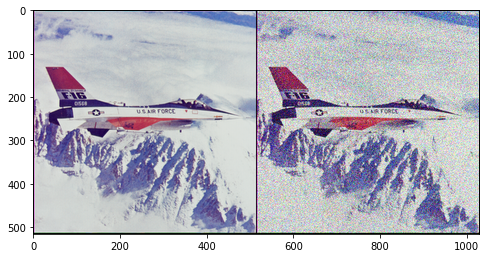

Number of params: 204495
Starting optimization with ADAM
Iteration 00000  Loss 0.100132  PSNR_noisy: 9.994262  PSNR_gt: 11.101276  PSNR_gt_sm: 11.101276  SSIM_noisy: 0.089272  SSIM_gt: 0.515029


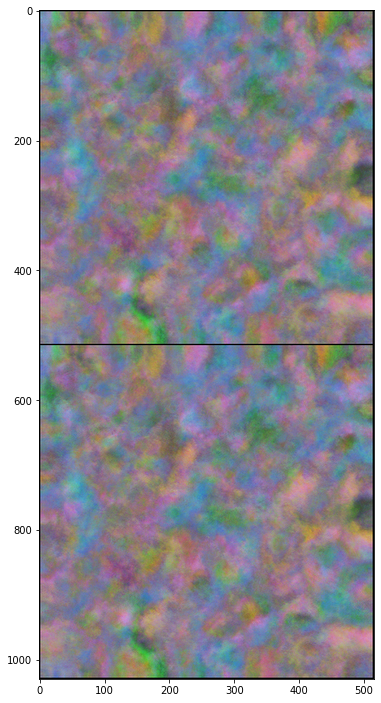

Iteration 00001  Loss 0.083073  PSNR_noisy: 10.805420  PSNR_gt: 12.337452  PSNR_gt_sm: 11.130959  SSIM_noisy: 0.093906  SSIM_gt: 0.599261
Iteration 00002  Loss 0.072641  PSNR_noisy: 11.388156  PSNR_gt: 13.357743  PSNR_gt_sm: 11.177949  SSIM_noisy: 0.096255  SSIM_gt: 0.660741
Iteration 00003  Loss 0.065555  PSNR_noisy: 11.833913  PSNR_gt: 14.257355  PSNR_gt_sm: 11.238779  SSIM_noisy: 0.098327  SSIM_gt: 0.699069
Iteration 00004  Loss 0.069540  PSNR_noisy: 11.577643  PSNR_gt: 13.916220  PSNR_gt_sm: 11.307709  SSIM_noisy: 0.098487  SSIM_gt: 0.709086
Iteration 00005  Loss 0.065814  PSNR_noisy: 11.816834  PSNR_gt: 14.377508  PSNR_gt_sm: 11.380350  SSIM_noisy: 0.098877  SSIM_gt: 0.714366
Iteration 00006  Loss 0.064357  PSNR_noisy: 11.914054  PSNR_gt: 14.545030  PSNR_gt_sm: 11.450886  SSIM_noisy: 0.099189  SSIM_gt: 0.717917
Iteration 00007  Loss 0.065361  PSNR_noisy: 11.846794  PSNR_gt: 14.392694  PSNR_gt_sm: 11.517651  SSIM_noisy: 0.098569  SSIM_gt: 0.714300
Iteration 00008  Loss 0.061858  PS

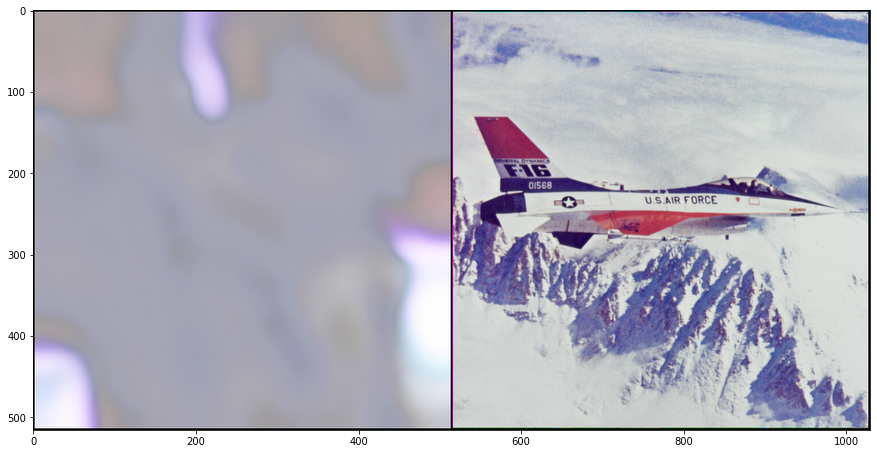

In [111]:
losses_comp, psnrs_noisy_comp, psnrs_gt_comp, ssims_noisy_comp, ssims_gt_comp = main_comp.main_func(compressed_model, True, device='cuda')

In [112]:
save_logs(
    './logs/', 
    {
        'losses_comp': losses_comp, 
        'psnrs_noisy_comp': psnrs_noisy_comp, 
        'psnrs_gt_comp': psnrs_gt_comp, 
        'ssims_noisy_comp': ssims_noisy_comp, 
        'ssims_gt_comp': ssims_gt_comp
    }
)

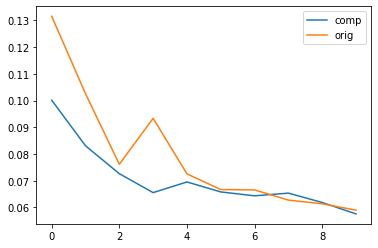

In [113]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses_comp, label='comp')
plt.plot(losses, label='orig')
plt.legend()